In [1]:
import sys
sys.path.insert(0,'..')

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import dlc_practical_prologue as prologue

In [55]:
def read_input(batch_size = 100, single_channel = True, normalize = True, pairs = 1000):
    
    train_input, train_target, train_classes, test_input, test_target, test_classes = \
        prologue.generate_pair_sets(pairs)
    
#     print('train_input', train_input.size(), 'train_target', train_target.size(), 'train_classes', train_classes.size())
#     print('test_input', test_input.size(), 'test_target', test_target.size(), 'test_classes', test_classes.size())
    
    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)
#         print('normalize: ', normalize)

    if single_channel:  
        train_input_sc = torch.cat((train_input[:,0,:,:], train_input[:,1,:,:]), 0).unsqueeze(1)
        train_classes_sc = torch.cat((train_classes[:,0], train_classes[:,1]), 0)
        test_input_sc = torch.cat((test_input[:,0,:,:], test_input[:,1,:,:]), 0).unsqueeze(1)
        test_classes_sc = torch.cat((test_classes[:,0], test_classes[:,1]), 0)

#         print('single channel: train_input_sc', train_input_sc.size(), 'train_target', train_target.size(), 'train_classes_sc', train_classes_sc.size())
#         print('single channel: test_input_sc', test_input_sc.size(), 'test_target', test_target.size(), 'test_classes_sc', test_classes_sc.size())
    
        trainDataset = TensorDataset(train_input_sc, train_classes_sc)
        testDataset = TensorDataset(test_input_sc, test_classes_sc)

        train_loader = DataLoader(trainDataset, batch_size, shuffle = False)
        test_loader = DataLoader(testDataset, batch_size, shuffle = False)

        test_target_Dataset = TensorDataset(test_input, test_target)
        test_target_loader = DataLoader(test_target_Dataset, batch_size, shuffle = False)

        return train_loader, test_loader, test_target_loader
    
    else:
        trainDataset = TensorDataset(train_input, train_target)
        testDataset = TensorDataset(test_input, test_target)

        train_loader = DataLoader(trainDataset, batch_size, shuffle = False)
        test_loader = DataLoader(testDataset, batch_size, shuffle = False)
        
        return train_loader, test_loader

In [100]:
class Net1(nn.Module):
    def __init__(self, nb_hidden = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(128, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = F.relu(self.fc1(x.view(-1, 128)))
        x = self.fc2(x)
        return x

class Net2(nn.Module):
    def __init__(self, nb_hidden = 256):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(1024, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
#         x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=1)
        x = F.relu(self.fc1(x.view(-1, 1024)))
        x = self.fc2(x)
        return x
    
class Net3(nn.Module):
    def __init__(self, nb_hidden = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [92]:
def train_model_epoch(model, optimizer, criterion, train_loader):
    tr_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        tr_loss += loss.item()

        loss.backward()
        optimizer.step()
        
    tr_loss = tr_loss/(batch_idx + 1)
    return tr_loss

def validate_model_epoch(model, criterion, test_loader):
    val_loss = 0
    correct_pred = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        pred = model(data)

        loss = criterion(pred, target)
        val_loss += loss.item()

        predicted_label = pred.max(1)[1]
        correct_pred += (predicted_label == target).sum()

    val_loss = val_loss/ (batch_idx + 1)  
    return val_loss, correct_pred

def train_model(model, train_loader, test_loader, learning_rate = 1e-2, epochs = 10, eval_ = True):
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr)
    #momentum=momentum
    
    tr_loss_list=[]
    val_loss_list=[]
    val_accuracy_list=[]
    
    for epoch in range(epochs):
        model.train()
        tr_loss = train_model_epoch(model, optimizer, criterion, train_loader)
        tr_loss_list.append(tr_loss)    
        
        if(eval_):
            model.eval()
            val_loss, correct_pred = validate_model_epoch(model, criterion, test_loader)
            val_accuracy = correct_pred / (test_loader.batch_size*len(test_loader))
            val_loss_list.append(val_loss)    
            val_accuracy_list.append(val_accuracy)    
            
            print('\nEpoch: {}/{}, Train Loss: {:.6f}, Val Loss: {:.6f}, Val Accuracy: {:.6f}% {}/{}'.format(epoch + 1, epochs, tr_loss, val_loss, 100*val_accuracy, correct_pred, test_loader.batch_size*len(test_loader)))
#         else:
#             print('\nEpoch: {}/{}, Train Loss: {:.6f}'.format(epoch + 1, epochs, tr_loss))

    return tr_loss_list, val_loss_list, val_accuracy_list

In [104]:
learning_rate, epochs, batch_size = 1e-1, 25, 10
train_loader, test_loader, test_target_loader = read_input(batch_size)
# train_loader, test_loader = read_input(batch_size, single_channel = False)

model = Net1()
tr_loss_l, val_loss_l, val_accuracy_l = train_model(model, train_loader, test_loader, learning_rate, epochs)


Epoch: 1/25, Train Loss: 1.213621, Val Loss: 0.790016, Val Accuracy: 73.199997% 1464/2000

Epoch: 2/25, Train Loss: 0.314449, Val Loss: 0.317783, Val Accuracy: 89.650002% 1793/2000

Epoch: 3/25, Train Loss: 0.203187, Val Loss: 0.340614, Val Accuracy: 89.000000% 1780/2000

Epoch: 4/25, Train Loss: 0.154575, Val Loss: 0.269988, Val Accuracy: 91.799995% 1836/2000

Epoch: 5/25, Train Loss: 0.132993, Val Loss: 0.246174, Val Accuracy: 93.349998% 1867/2000

Epoch: 6/25, Train Loss: 0.077673, Val Loss: 0.254079, Val Accuracy: 94.250000% 1885/2000

Epoch: 7/25, Train Loss: 0.087050, Val Loss: 0.247408, Val Accuracy: 93.699997% 1874/2000

Epoch: 8/25, Train Loss: 0.069928, Val Loss: 0.291593, Val Accuracy: 93.049995% 1861/2000

Epoch: 9/25, Train Loss: 0.052889, Val Loss: 0.229265, Val Accuracy: 94.550003% 1891/2000

Epoch: 10/25, Train Loss: 0.062498, Val Loss: 0.208937, Val Accuracy: 94.849998% 1897/2000

Epoch: 11/25, Train Loss: 0.050576, Val Loss: 0.253044, Val Accuracy: 94.250000% 1885/20

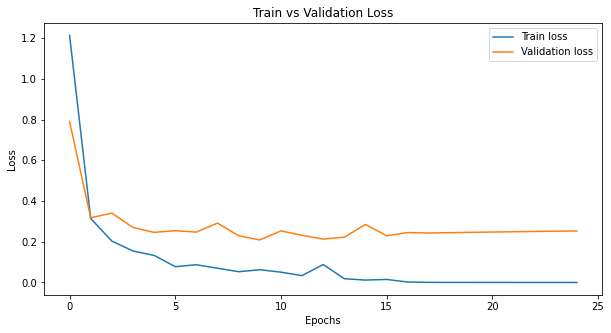

In [105]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
plt.plot(tr_loss_l, label="Train loss")
plt.plot(val_loss_l, label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Train vs Validation Loss")
plt.legend(loc='upper right')
plt.show()

In [106]:
def predict_sc_accuracy_round(model, test_loader):
    model.eval()

    correct_pred = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        pred_first = model(data[:,0,:,:].unsqueeze(1))
        predicted_label_first = pred_first.max(1)[1]

        pred_second = model(data[:,1,:,:].unsqueeze(1))
        predicted_label_second = pred_second.max(1)[1]

        predicted_label = (predicted_label_first <= predicted_label_second)
        correct_pred += (predicted_label.int() == target).sum()

    return correct_pred

In [107]:
def predict_sc_accuracy(batch_size, learning_rate, epochs, rounds):
    
    val_accuracy_list = []

    for round_ in range(rounds):

        train_loader, test_loader, test_target_loader = read_input(batch_size)

        model = Net1()

        _,_,_ = train_model(model, train_loader, test_loader, learning_rate, epochs, eval_=False)

        nb_correct_pred = predict_single_channel(model, test_target_loader)

        val_accuracy = nb_correct_pred / (test_target_loader.batch_size*len(test_target_loader))
        val_accuracy_list.append(val_accuracy)
        
        print('\nRound: {}/{}, Val Accuracy: {:.6f}% {}/{}'.format(round_+1, rounds, 100*val_accuracy, nb_correct_pred, test_target_loader.batch_size*len(test_target_loader)))
        
    return val_accuracy_list

In [108]:
batch_size, learning_rate, epochs, rounds = 10, 1e-1, 20, 10
val_accuracy_list = predict_sc_accuracy(batch_size, learning_rate, epochs, rounds)


Round: 1/10, Val Accuracy: 97.199997% 972/1000

Round: 2/10, Val Accuracy: 97.500000% 975/1000

Round: 3/10, Val Accuracy: 97.899994% 979/1000

Round: 4/10, Val Accuracy: 97.099998% 971/1000

Round: 5/10, Val Accuracy: 97.199997% 972/1000

Round: 6/10, Val Accuracy: 98.000000% 980/1000

Round: 7/10, Val Accuracy: 97.399994% 974/1000

Round: 8/10, Val Accuracy: 98.000000% 980/1000

Round: 9/10, Val Accuracy: 96.500000% 965/1000

Round: 10/10, Val Accuracy: 97.099998% 971/1000


No handles with labels found to put in legend.


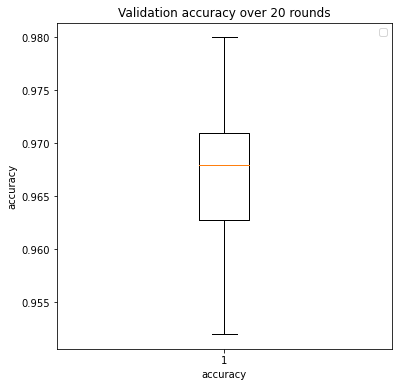

In [94]:
fig = plt.figure(figsize=(6, 6))
plt.boxplot([val_accuracy_list])
plt.xlabel('accuracy')
plt.ylabel('accuracy')
plt.title(f'Validation accuracy over {rounds} rounds')
plt.legend(loc='upper right')
plt.show()